In [ ]:
!pip install pycaret 

##### Cargue de librerias

In [1]:
from pycaret.clustering import *

import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint

import warnings
warnings.filterwarnings("ignore")

In [16]:
df_3 = pd.read_csv('C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Clustering/base clustering encriptado.csv',
                    encoding = 'unicode_escape', decimal= ",", sep= ";")

##### Creacion, ajuste y descarga de los modelos de clustering por cada distrito-tipo de zona

In [17]:
list_dtos = df_3["Distrito-Nombretipozona"].unique()
numeric_features = ["Recency", "Monetary", "Frequency"]
ignore_columns = ["Codigo distrito", "Nombre tipo zona", "Nit cliente-sucursal", "Distrito-Nombretipozona"]
normalizar = [False, True]

##### Dos modelos, norm= True y norm= False

In [18]:
# Variables iniciales
bd_predicted = pd.DataFrame([])
metrics = []

# Fecha para guardar resultados
fecha = '14-2-23'

# Ciclo para realizar el modelo de clustering por cada tipo de zona del pais
for norm in normalizar:
    for n, dto in enumerate(list_dtos):
        print(f"Procesando modelo normalizado {norm} {n+1} de {len(list_dtos)}. {(n+1) / (len(list_dtos)):.1%}")
        
        #BD filtrada
        df_dto = df_3[df_3["Distrito-Nombretipozona"] == dto]
        
        #Setup del modelo 
        s = setup(
                    df_dto,
                    normalize = norm,
                    verbose= False,
                    preprocess= False,
                    silent= True,
                    profile= False,
                    ignore_features= ignore_columns,
                    numeric_features= numeric_features
                    )
        
        #Creacion y prediccion de modelo
        model_kmeans = create_model(
                                    'kmeans',
                                    num_clusters= 5,
                                    verbose= False,
                                    )
        pull()
        df_pred_km = predict_model(
                                    model_kmeans,
                                    data = df_dto
                                    )
        
        # Reasignacion de los nombres de los clusters
        trans = df_pred_km.groupby(
                                    ["Cluster"]).agg({
                                                    "Recency": np.mean, "Monetary": np.mean, "Frequency": np.mean,
                                                    }).sort_values(
                                                                    by= ["Monetary", "Frequency", "Recency"],
                                                                    ascending= False
                                                                    ).reset_index()
        trans["Letra cluster"] = ["A", "B", "C", "D", "E"]
        trans = trans[["Cluster", "Letra cluster"]]
        
        df_pred_km = pd.merge(df_pred_km, trans, on= ["Cluster"])
        
        # Descarga del modelo
        bd_predicted = bd_predicted.append(df_pred_km)

        #Append a la variable incial de metricas
        metrics.append({
                        "Distrito-zona": dto,
                        "Normalizado": norm,
                        "Silhouette": pull().Silhouette[0],
                        "Calinski-Harabasz": pull()["Calinski-Harabasz"][0],
                        "Davies-Bouldin": pull()["Davies-Bouldin"][0]
                        })
        # save_model(model_kmeans, f"C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Clustering/Modelos {fecha}/Modelo {dto} {fecha}")

# Transformacion de la variable de metricas
metrics = pd.DataFrame(metrics)
metrics["Normalizado"] = metrics["Normalizado"].replace([True, False], ["Si","No"])
metrics["Tipo zona"] = metrics["Distrito-zona"].str[4:]

print("Proceso completo 100%")

Procesando modelo normalizado False 1 de 67. 1.5%
Procesando modelo normalizado False 2 de 67. 3.0%
Procesando modelo normalizado False 3 de 67. 4.5%
Procesando modelo normalizado False 4 de 67. 6.0%
Procesando modelo normalizado False 5 de 67. 7.5%
Procesando modelo normalizado False 6 de 67. 9.0%
Procesando modelo normalizado False 7 de 67. 10.4%
Procesando modelo normalizado False 8 de 67. 11.9%
Procesando modelo normalizado False 9 de 67. 13.4%
Procesando modelo normalizado False 10 de 67. 14.9%
Procesando modelo normalizado False 11 de 67. 16.4%
Procesando modelo normalizado False 12 de 67. 17.9%
Procesando modelo normalizado False 13 de 67. 19.4%
Procesando modelo normalizado False 14 de 67. 20.9%
Procesando modelo normalizado False 15 de 67. 22.4%
Procesando modelo normalizado False 16 de 67. 23.9%
Procesando modelo normalizado False 17 de 67. 25.4%
Procesando modelo normalizado False 18 de 67. 26.9%
Procesando modelo normalizado False 19 de 67. 28.4%
Procesando modelo normaliza

In [19]:
metrics

,Distrito-zona,Normalizado,Silhouette,Calinski-Harabasz,Davies-Bouldin,Tipo zona
0,101-Artes graficas,No,0.7661,2134.2232,0.5120,Artes graficas
1,101-Institucional,No,0.9437,14490.4983,0.1813,Institucional
2,101-Mayorista,No,0.7980,2010.1265,0.3790,Mayorista
3,101-TIG,No,0.8988,6948.8845,0.2565,TIG
4,101-V Horeca,No,0.7142,2685.7809,0.2087,V Horeca
...,...,...,...,...,...,...
129,116-Institucional,Si,0.8705,2290.0138,0.3489,Institucional
130,116-Mayorista,Si,0.8336,3058.4100,0.3456,Mayorista
131,117-Artes graficas,Si,0.7866,4064.3158,0.4292,Artes graficas
132,117-Institucional,Si,0.8305,4233.5250,0.3621,Institucional


##### Visualizacion y validacion clustering

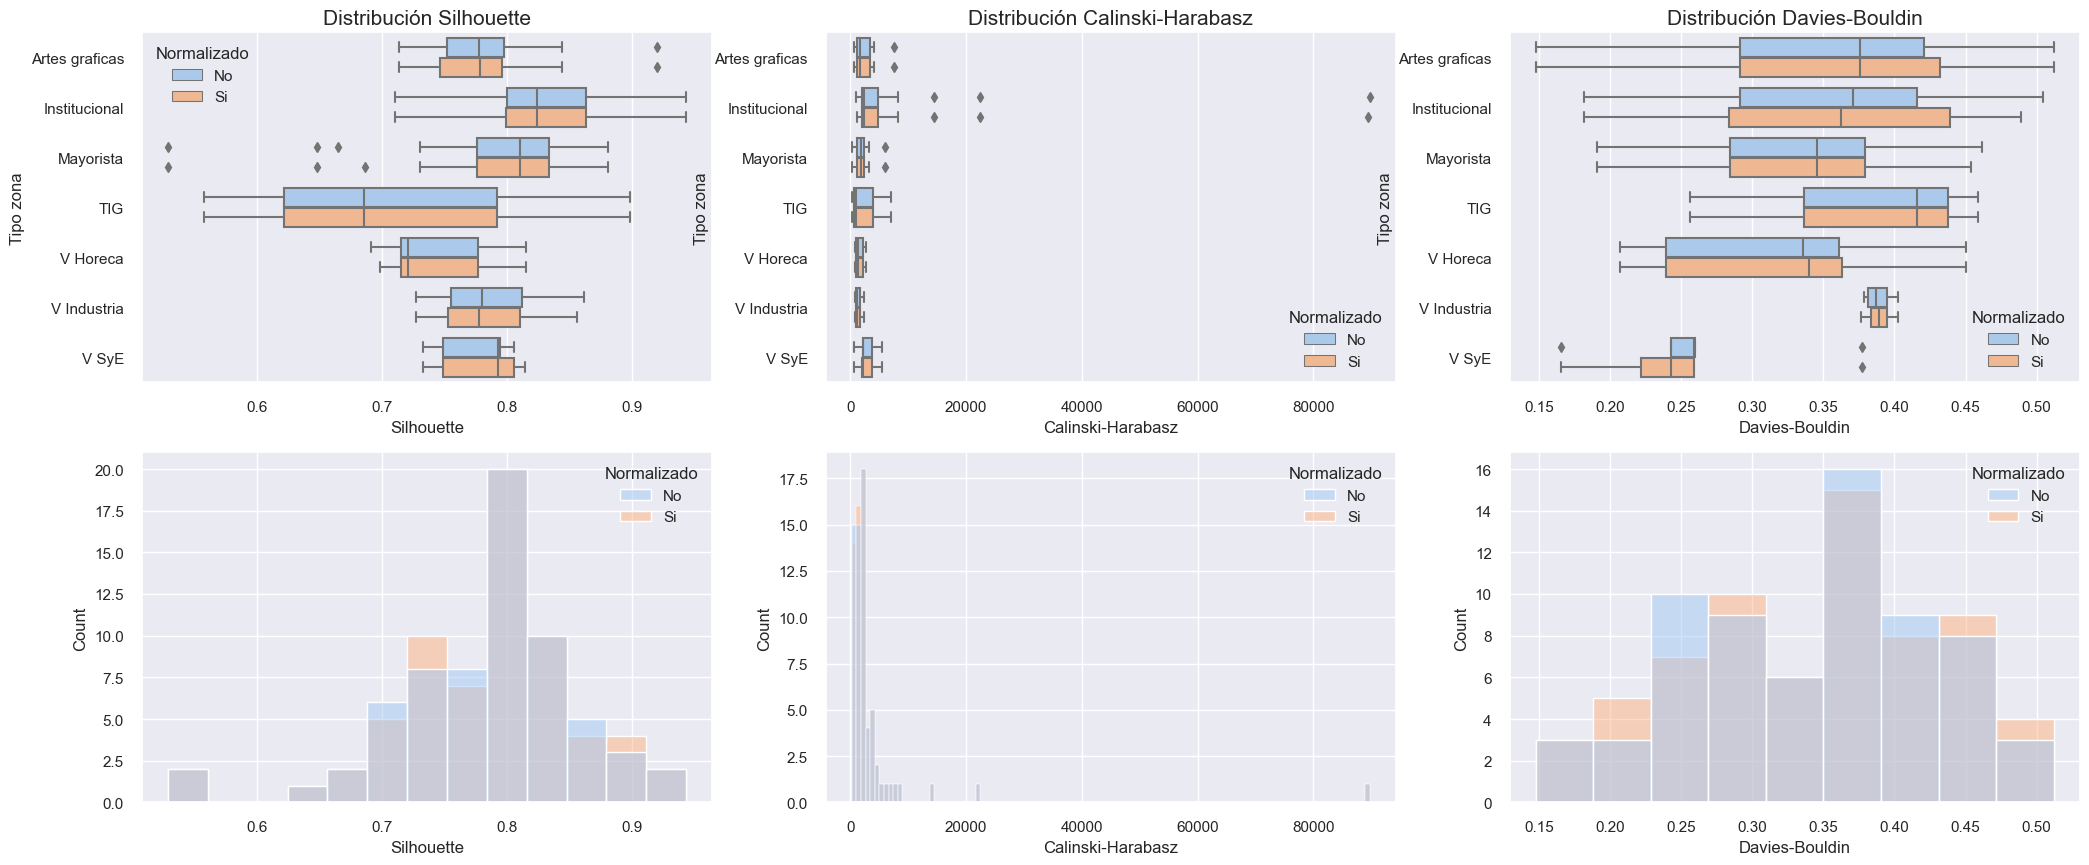

In [20]:
# Plots para validar si hay diferencia o no entre la data normalizada o no
f, axarr = plt.subplots(2,3)
f.set_figheight(10)
f.set_figwidth(25)

metricas = ["Silhouette", "Calinski-Harabasz", "Davies-Bouldin"]

for n, met in enumerate(metricas):
    f.add_subplot(axarr[0,n])
    plt.title(f"Distribución {met}").set_fontsize(15)
    sns.set_theme(style="darkgrid", palette= "pastel")
    sns.boxplot(data= metrics, x= met, y= "Tipo zona", hue= 'Normalizado')

    f.add_subplot(axarr[1,n])
    sns.set_theme(style="darkgrid", palette= "pastel")
    sns.histplot(data= metrics, x= met, hue= 'Normalizado')
plt.show()



No hay diferencia significativa entre la data normalizada y no normalizada

In [21]:
# Describe de las metricas normalizadas
metrics[metrics['Normalizado'] == "Si"].describe()

,Silhouette,Calinski-Harabasz,Davies-Bouldin
count,67.000000,67.000000,67.000000
mean,0.785945,4079.223660,0.343942
std,0.072950,11081.329853,0.089923
min,0.528600,233.687700,0.147600
25%,0.743250,1195.595050,0.273000
50%,0.795300,2011.514200,0.360100
75%,0.829850,3168.914300,0.417500
max,0.943700,89392.125100,0.512000


In [22]:
# Describe de las metricas NO normalizadas
metrics[metrics['Normalizado'] == "No"].describe()

,Silhouette,Calinski-Harabasz,Davies-Bouldin
count,67.000000,67.000000,67.000000
mean,0.785064,4077.019600,0.343454
std,0.073478,11128.682577,0.086935
min,0.528600,233.687700,0.147600
25%,0.741300,1195.595050,0.273650
50%,0.795000,2005.189500,0.360100
75%,0.829600,3165.974150,0.409100
max,0.943700,89784.107400,0.512000


Text(0.5, 0, 'Frequency')

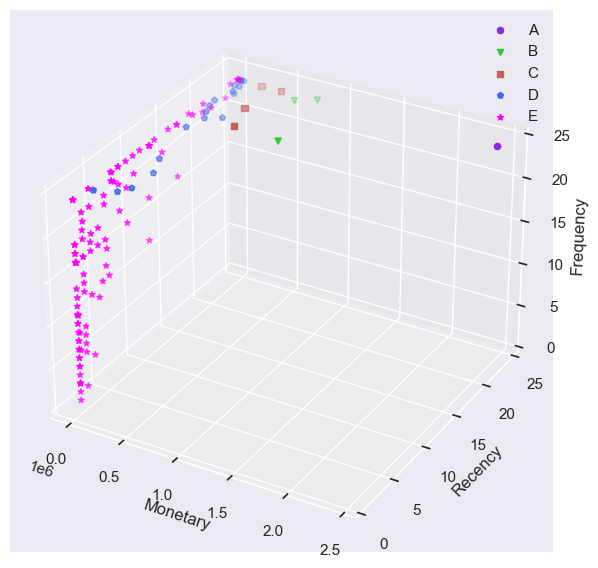

In [23]:
# Visualizacion del ultimo modelo creado
fig = plt.figure(figsize=(7,10))
ax = fig.gca(projection='3d')

m = ['o', 'v', 's', 'p', '*']
col =  ['blueviolet', 'limegreen', 'indianred', 'royalblue', 'magenta']
# leg = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3', 'Cluster 4']
leg = ['A', 'B', 'C', 'D', 'E']
cluster = list(np.unique(df_pred_km['Letra cluster']))

for c in range(5):
    df_plot = df_pred_km[df_pred_km['Letra cluster'] == cluster[c]]
    ax.scatter(df_plot['Monetary'],df_plot['Frequency'], df_plot['Recency'] , marker= m[c], c= col[c])
    
ax.legend(leg)
ax.set_xlabel('Monetary')
ax.set_ylabel('Recency')
ax.set_zlabel('Frequency')

In [24]:
plot_model(model_kmeans, plot = 'cluster')

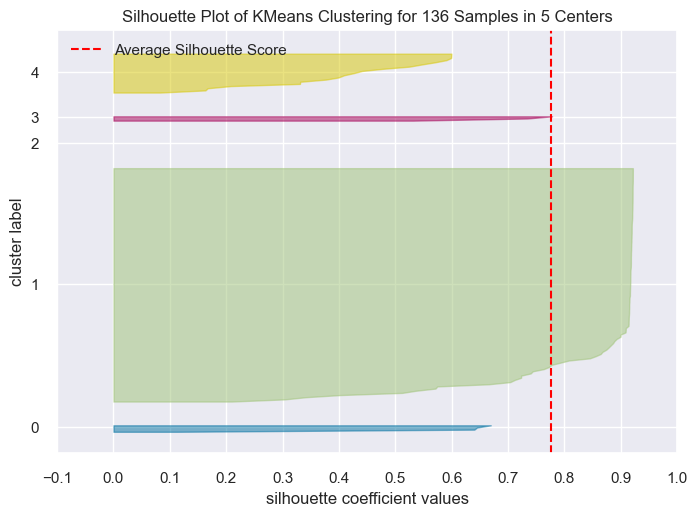

In [25]:
plot_model(model_kmeans, plot = 'silhouette')

In [26]:
plot_model(model_kmeans, plot = 'distribution')